In [81]:
import os
from time import sleep
import h5py
import numpy as np
from skimage.measure import label, regionprops
from skimage.filters import gaussian
from skimage.util.dtype import convert
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook
from bokeh.models import HoverTool, CustomJS, Slider, ColumnDataSource
from bokeh.layouts import row, column, gridplot
import matplotlib.pyplot as plt
# import mahotas as mh
output_notebook()

Loading BokehJS ...

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [6]:
# file_dir = '/home/aquiles/Documents/Data/Tracking/run100nm'
file_dir = 'C:\\Users\\aquiles\\Data\\run100nm'
filename = 'data.h5'
with h5py.File(os.path.join(file_dir, filename)) as file:
    data = file['Basler data'][:,:,:]
frames = np.linspace(1, data.shape[0], data.shape[0])

In [28]:
bkg = gaussian(data[0,:,:], 10).astype(data.dtype)
clear_data = data[0, :, :]-bkg
clear_data = np.clip(clear_data, 0, np.max(clear_data))

In [29]:
p = figure(x_range=(1, 300), y_range=(1, 250))
hover = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.add_tools(hover)
img = clear_data
source = ColumnDataSource(data=dict(image=[img]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
show(p)

In [30]:
threshold = 250
mask = clear_data>threshold
source = ColumnDataSource(data=dict(image=[mask]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
show(p)

In [11]:
labels = label(mask)

In [12]:
source = ColumnDataSource(data=dict(image=[labels]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
show(p)

In [13]:
props = regionprops(labels, clear_data)

In [9]:
diameters = [p['filled_area'] for p in props]

In [10]:
p1 = figure(title="Histogram of pixel number",background_fill_color="#E8DDCB")
hist, edges = np.histogram(diameters, density=True, bins=50)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
p1.xaxis.axis_label = 'Equivalent diameter (px)'
show(p1)

In [11]:
centroids = [p['centroid'] for p in props if p['filled_area']>4]

In [12]:
p = figure(x_range=(1, 300), y_range=(1, 250))
hover = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.add_tools(hover)
img = data[0,:,:]-bkg
source = ColumnDataSource(data=dict(image=[clear_data]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
for c in centroids:
    p.circle(c[1]+1,c[0]+1,fill_alpha=0, radius=4)
show(p)

In [50]:
def find_particles(img, bkg=None, threshold=None, min_size=0):
    if bkg is None:
        bkg = gaussian(img, 10)
    bkg.astype(np.uint16)
    img = convert(img-bkg,np.uint8) #<- This changes the execution speed ~5-fold
    if threshold is None:
        threshold = mh.otsu(img)
#     mask = img>threshold
#     labels = np.array(mh.label(img>threshold)[0])
    labels = label(img>threshold) # <- This is faster
    props = regionprops(labels, img, cache=True) # <- Cache True is faster
#     num_pixels = [p['filled_area'] for p in props]
    centroids = [p['centroid'] for p in props if p['filled_area']>=min_size]
    return centroids

In [33]:
%%timeit -n 1 -r 1

c = find_particles(data[0,:,:], bkg=bkg, threshold=250, min_size=5)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


861 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
centroids = find_particles(data[0,:,:], bkg=bkg, threshold=0, min_size=5)
len(centroids)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


37

In [61]:
p = figure(x_range=(1, 300), y_range=(1, 250))
hover = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@name")])
p.add_tools(hover)
img = convert(data[0,:,:]-bkg, np.uint16)
source = ColumnDataSource(data=dict(image=[img]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
for c in centroids:
    p.circle(c[1]+1,c[0]+1,fill_alpha=0, radius=4, name=str(c[0]))
show(p)

In [101]:
np.min(data)

0

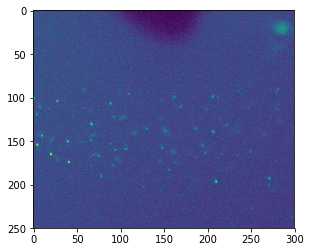

In [106]:
imgs = data.astype(np.uint16)
plt.imshow(imgs[0])
plt.show()

In [68]:
import threading

In [69]:
i = 0
def find_centroids(data, bkg):
    global i
    centroids = [()]*data.shape[0]
    for i in range(data.shape[0]):
        centroids[i] = find_particles(data[i,:,:], bkg=bkg, threshold=0, min_size=5)

In [86]:
t = threading.Thread(target=find_centroids, args=[data, bkg])
t.start()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [87]:
old_i = 0
while t.is_alive():
    fps, old_i = (i-old_i)*2, i
    sleep(0.5)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


KeyboardInterrupt: 

In [ ]:
i